# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://upload.wikimedia.org/wikipedia/commons/f/f7/MnistExamplesModified.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Константи

In [2]:
num_classes = 10  # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784  # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001  # швидкість навчання нейронної мережі
training_steps = 3000  # максимальне число епох
batch_size = 256  # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
# кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності
display_step = 100

n_hidden_1 = 128  # кількість нейронів 1-го шару
n_hidden_2 = 256  # кількість нейронів 2-го шару


# Підготовка навчальногог та тестового наборів

In [3]:
from keras.datasets import mnist

# Завантажуємо датасет і розділимо його на навчальну та тестову вибірки.
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape(
    [-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)


# Створення нейронної мережі

Структура мережі

1. Один вхідний шар `input_layer`. Кількість нейронів - 784 (вхідні ознаки для кожного пікселя зображення розміром $28 \times 28 = 784$ пікселів).
2. Перший прихований шар `hidden_layer_1`. Кількість нейронів - 128 (згідно з `n_hidden_1`).
3. Другий прихований шар `hidden_layer_2`. Кількість нейронів - 256 (згідно з `n_hidden_2`).
4. Вихідний шар `output_layer`. Кількість нейронів - 10 (кількість класів, відповідаючих цифрам від 0 до 9).
   
В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда `tf.nn.sigmoid`. На вихідному шарі ми використовуємо softmax `tf.nn.softmax`.

<img src="./TeX/NN.png" alt="nnmnist" style="width: 1000px;"/>



In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    """
    A custom dense (fully connected) layer for neural networks.

    This class represents a dense layer that performs a linear transformation
    followed by a sigmoid activation function.

    Attributes:
        in_features (int): The number of input features.
        out_features (int): The number of output features.
        name (str, optional): The name of the layer.

    Methods:
        __init__(self, in_features, out_features, name=None):
            Initializes the dense layer with random weights and zeros for bias.
        __call__(self, x):
            Applies the dense layer to the input tensor x.

    Example usage:
    dense_layer = DenseLayer(64, 128, name="hidden_layer")
    output = dense_layer(input_data)
    """

    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)

        # Initialize weights with random values
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )

        # Initialize bias with zeros
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        """
        Apply the dense layer to the input tensor.

        Args:
            x (tf.Tensor): The input tensor.

        Returns:
            tf.Tensor: The output tensor after applying the dense layer.
        """

        sigma = x @ self.w + self.b

        if activation != 0:
            return tf.nn.softmax(sigma)
        else:
            return tf.nn.sigmoid(sigma)


class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        # Перший шар, який складається з 128 нейронів
        self.layer1 = DenseLayer(
            num_features, n_hidden_1, name='hidden_layer1'
        )

        # Другий шар, який складається з 256 нейронів
        self.layer2 = DenseLayer(
            n_hidden_1, n_hidden_2, name='hidden_layer2'
        )

        # Вихідний шар
        self.out_layer = DenseLayer(
            n_hidden_2, num_classes, name='output_layer'
        )

    def __call__(self, x):
        # Передача даних через перші два шари з функцією активації sigmoid
        x = self.layer1(x, activation=0)
        x = self.layer2(x, activation=0)

        # Передача у вихідний шар з функцією softmax
        x = self.out_layer(x, activation=1)

        return x


# Метрики

In [5]:
# У якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(p_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    p_pred = tf.clip_by_value(p_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(p_pred)))

# Як метрику якості використовуємо точність


def accuracy(p_pred, y_true):
    """
    Обчислює точність класифікації на основі передбачених класів та справжніх міток.

    Параметри:
    ----------
    p_pred (tf.Tensor): Тензор, який містить передбачені ймовірності для кожного класу для кожного прикладу.
    y_true (tf.Tensor): Тензор, який містить справжні класи (мітки) для кожного прикладу.

    Повертає:
    ---------
    Точність класифікації, від 0 до 1.

    Примітки:
    ---------
    Ця функція порівнює передбачені класи (на основі ймовірностей в p_pred) зі
    справжніми мітками у y_true та обчислює точність класифікації.

    """

    # Знайдемо індекс максимальної ймовірності у векторі p_pred
    # Індекс є нашою цифрою
    predicted_class = tf.argmax(p_pred, axis=1)

    # Порівняємо передбачені класи зі справжніми мітками
    correct_prediction = (predicted_class == tf.cast(y_true, tf.int64))

    # Обчислимо точність
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    return accuracy


# Екземпляр мережі та функція тренування

In [6]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі


def train(neural_net, input_x, output_y):
    # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
    optimizer = tf.optimizers.SGD(learning_rate)

    # Активація автоматичного диференціювання
    with tf.GradientTape() as tape:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y)

        # Отримаємо список оптимізованих параметрів
        trainable_variables = neural_net.trainable_variables

        # Обчислимо за ними значення градієнта
        gradient = tape.gradient(loss, trainable_variables)

        # Модифікуємо параметри
        optimizer.apply_gradients(zip(gradient, trainable_variables))


# Тренування мережі

In [7]:
# Тренування мережі
import time
from IPython.display import clear_output

# кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
loss_history = []
# кожні display_step кроків зберігай в цьому списку поточну точність нейромережі
accuracy_history = []
steps = []

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acc)
        steps.append(step)

        data_row = f'Step: {step:<4d} | Loss: {loss:>7.1f} | Accuracy: {acc:.2f}'

        clear_output(wait=True)
        print(data_row)
else:
    print("Тренування завершено.")


Step: 3000 | Loss:    64.0 | Accuracy: 0.91
Тренування завершено.


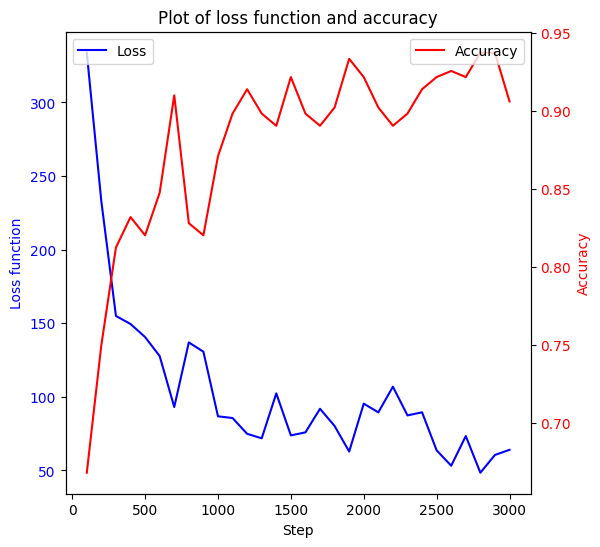

In [8]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

fig, ax1 = plt.subplots(figsize=(6, 6))
ax2 = ax1.twinx()

# Графік функції втрат
ax1.plot(steps, loss_history, linestyle='-', color='b', label='Loss')
ax1.set_title('Plot of loss function and accuracy')
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss function', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend(loc='upper left')

# Графік точності
ax2.plot(steps, accuracy_history, linestyle='-', color='r', label='Accuracy')
ax2.set_ylabel('Accuracy', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc='upper right')

plt.show()


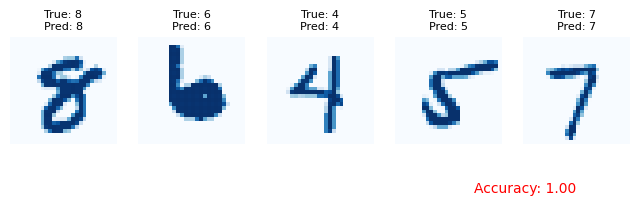

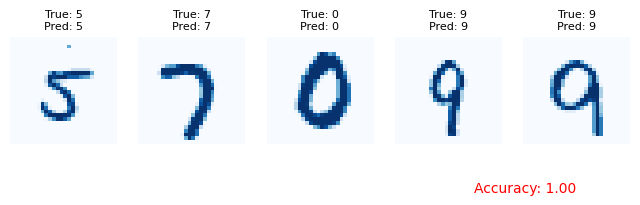

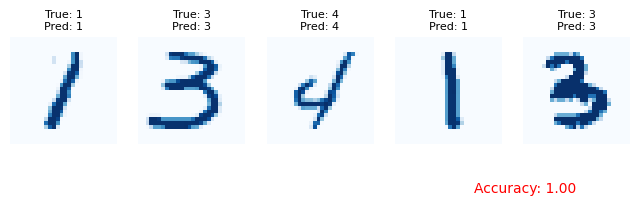

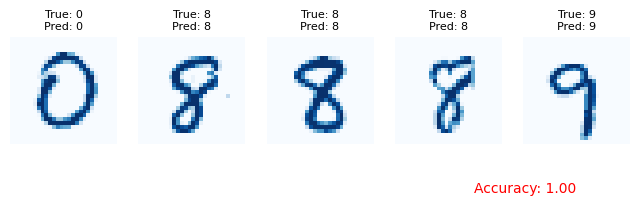

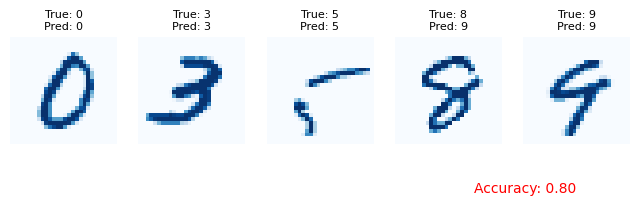

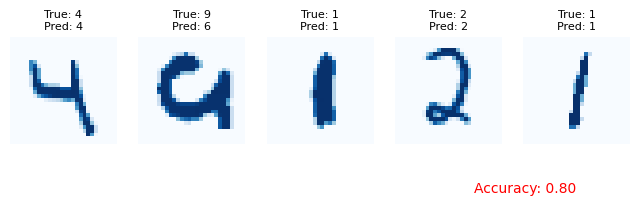

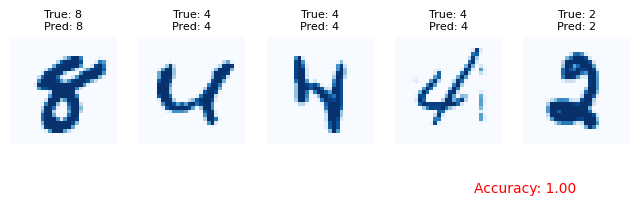

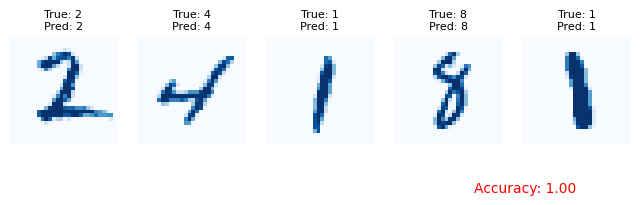

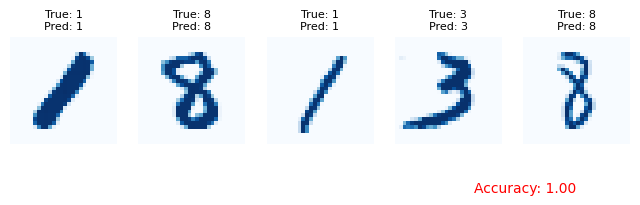

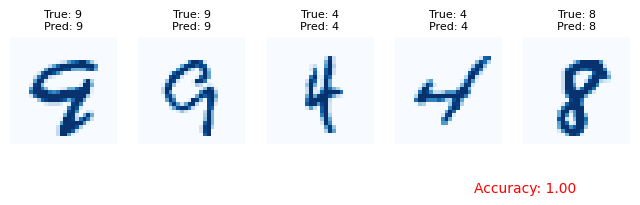

In [9]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

# Виберемо 5 випадкових зображень з тестової вибірки
sample_size = 5
acc_list = []
for iteration in range(10):
    random_indices = np.random.choice(x_test.shape[0], sample_size)
    test_images = x_test[random_indices]
    test_digits = y_test[random_indices]

    # Прогнозуємо йовірності вибраних зображень
    p_pred = neural_net(test_images)

    # На основі ймовірностей прогнозуємо клас
    pred_digits = tf.argmax(p_pred, axis=1).numpy()

    # Виведемо зображення та випишемо поруч відповідь нейромережі
    plt.figure(figsize=(8, 4))
    for i in range(sample_size):
        plt.subplot(1, sample_size, i + 1)
        plt.imshow(test_images[i].reshape((28, 28)), cmap='Blues')
        plt.title(
            f"True: {test_digits[i]}\nPred: {pred_digits[i]}", fontsize=8)
        plt.axis('off')
    acc = np.mean(test_digits == pred_digits)
    acc_list.append(acc)
    plt.text(0, 40, f'Accuracy: {acc:.2f}', ha='center', c='r')
    plt.show()


# Висновки

Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

Для того, щоб визначити, як часто помиляється наша мережа, визначимо точність для `sample_size` випадкових зображень з тестової вибірки. Зробимо 10 таких ітерацій і усереднимо значення точностей.

In [10]:
acc = np.mean(acc_list)
print(f"Accuracy: {acc:.2f}")


Accuracy: 0.96


Видно, що наша мережа звісно, помиляється, але точність достатньо висока. Деякі рукописні цифри я і сам би визначив не правильно, нейронка при цьому визначала правильно, є випадки, де нейронка помиляється "тупо", очевидно, що цифра не така, яку передбачає нейронка. Тому, можна сказати, що мережа помиляється в "середньому" так як і людина. 

Наступне вже не стосується даного прикладу.

В цілому, було б непогано створити таку нейронку, щоб вона розпізнавала рукописний текст краще ніж людина, і більше того, необхідно, щоб вміла розпізнавати рукописні тексти грунтуючись не лише на зображені окремих символів, а аналізувала контекст. Це може бути актуально для розшифровки рукописного тексту лікарів, щоб було як в анекдоті:

<div style="background-color: #f5f5f5; border: 1px solid #dcdcdc; padding: 10px; border-radius: 5px; box-shadow: 3px 3px 5px 0px #ccc;">
    <p style="color: #555;"> - Як екзаменують почеркознавців?</p>
    <p style="color: #555;"> - Треба розібрати почерк п'яного лікаря, який пише вкраденою на пошті ручкою і їде в розхлябаному возі по бруківці.</p>
</div>


